In [61]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
import wfdb
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix

def read_records(record_files):
    records = []
    labels = []
    for record_file in record_files:
        record = wfdb.rdrecord(record_file)
        if record.file_name[0].endswith('.dat'):
            # TODO work out how to deal with MIT-BIH with its different hea/atr/dat files
            # and very low samples. Split into many files?
            ann = wfdb.rdann(record_file,'atr')
        else:
            for comment in record.comments:
                if comment.startswith('Dx') or comment.startswith(' Dx'):
                    dxs = set(arr.strip() for arr in comment.split(': ')[1].split(','))
                    labels.append(dxs)
                    
        records.append(wfdb.rdrecord(record_file))
    return records, labels


def create_one_hot_labels(all_labels, target_classes, num_recordings):
    discard_index = list()
    labels = np.zeros((num_recordings, len(target_classes)))#, dtype=np.bool)
    for i in range(num_recordings):
        dxs = all_labels[i]
        flag = np.zeros((1,len(dxs)), dtype = bool)
        count = 0
        for dx in dxs:
            if dx in target_classes:
                j = target_classes.index(dx)
                labels[i, j] = 1
                flag [0 ,count] = True

            count += 1

        # note any recordings that don't have any of the classes we are looking for
        if np.any(flag) == False:
            discard_index.append(i)

    return labels, discard_index

def get_unique_classes(all_labels, valid_classes=None):

    classes2 = list()
    for i in range(len(all_labels)):
        dxs = all_labels[i]
        for dx in dxs:
            if valid_classes is None or dx in valid_classes:
                classes2.append(dx)

    classes3 = list()
    for x in classes2:
        if x not in classes3:
            classes3.append(x)

    classes3 = sorted (classes3)
    return classes3

def find_records(directory):
    record_files = []
    for dirpath, _, filenames in os.walk(directory):
        for f in sorted(filenames):
            file_path = os.path.join(dirpath, f)
            if os.path.isfile(file_path) and not f.lower().startswith('.'):
                file, ext = os.path.splitext(file_path)
                if ext.lower() == '.hea':
                    record_files.append(file)
    if record_files:
        return record_files
    else:
        raise IOError('No record files found.')

def filter(data, labels, index):
    labels = [labels[i] for i in range(len(labels)) if i not in index]
    data = [data[i] for i in range(len(data)) if i not in index]
    return labels, data

def consolidate_equivalent_classes(one_hot_encoded_labels, unique_classes):
    equivalent_classes_collection = [['713427006', '59118001'], ['284470004', '63593006'], ['427172004', '17338001']]

    # For each set of equivalent class, use only one class as the representative class for the set and discard the other classes in the set.
    # The label for the representative class is positive if any of the labels in the set is positive.
    remove_classes = list()
    remove_indices = list()
    for equivalent_classes in equivalent_classes_collection:
        equivalent_classes = [x for x in equivalent_classes if x in unique_classes]
        if len(equivalent_classes)>1:
            other_classes = equivalent_classes[1:]
            equivalent_indices = [unique_classes.index(x) for x in equivalent_classes]
            representative_index = equivalent_indices[0]
            other_indices = equivalent_indices[1:]

            one_hot_encoded_labels[:, representative_index] = np.any(one_hot_encoded_labels[:, equivalent_indices], axis=1)
            remove_classes += other_classes
            remove_indices += other_indices

    for x in remove_classes:
        unique_classes.remove(x)
    labels = np.delete(labels, remove_indices, axis=1)

    return labels, unique_classes

def set_labels_to_normal_if_none_other(labels, unique_classes, normal_class):
    # If the labels are negative for all classes, then change the label for the normal class to positive.
    normal_index = unique_classes.index(normal_class)
    for i in range(len(labels)):
        num_positive_classes = np.sum(labels[i, :])
        if num_positive_classes==0:
            labels[i, normal_index] = 1

    return labels

def ensure_normal_class(unique_classes, normal_class):
    if normal_class not in unique_classes:
        unique_classes.add(normal_class)
        print('- The normal class {} is not one of the label classes, so it has been automatically added, but please check that you chose the correct normal class.'.format(normal_class))
    unique_classes = sorted(unique_classes)
    return unique_classes

def read_scored_classes():
    scored = list()
    with open('dx_mapping_scored.csv', 'r') as f:
        for l in f:
            dxs = (l.split(','))
            scored.append(dxs[1])
    return (sorted(scored[1:]))

def filter_out(one_hot_encoded_labels, records, discard_index):
    one_hot_encoded_labels = [one_hot_encoded_labels[i] for i in range(len(one_hot_encoded_labels)) if i not in discard_index]
    records = [records[i] for i in range(len(records)) if i not in discard_index]

    return one_hot_encoded_labels, records

def load_records(record_file_list, adjust_classes_for_physionet, normal_class):
        
    if len(record_file_list) == 0:
        raise ValueError('No record files found.')

    num_recordings = len(record_file_list)

    records, all_labels = read_records(record_file_list)

    scored = None
    if adjust_classes_for_physionet:
        scored = read_scored_classes()

    unique_classes = get_unique_classes(all_labels, scored)

    if (normal_class is not None):
        unique_classes = ensure_normal_class(unique_classes, normal_class)
    
    one_hot_encoded_labels, discard_index = create_one_hot_labels(all_labels, unique_classes, num_recordings)

    if (adjust_classes_for_physionet):
        one_hot_encoded_labels, unique_classes = consolidate_equivalent_classes(one_hot_encoded_labels, unique_classes)
    
    if (normal_class is not None):
        one_hot_encoded_labels = set_labels_to_normal_if_none_other(one_hot_encoded_labels, unique_classes, normal_class)
    
    one_hot_encoded_labels, records = filter_out(one_hot_encoded_labels, records, discard_index)

    return one_hot_encoded_labels, records

def standardise_length(data, target_length):
    number_of_leads = data.shape[0]
    
    if len(data[0])<=target_length:
        ext= np.zeros([number_of_leads,target_length])
        for i in range(0,number_of_leads):
            ext[i][0:len(data[i])]=data[i]
        return ext.T  
    else:
        cut = np.zeros([number_of_leads,target_length])
        for i in range(number_of_leads):
            tocut = len(data[0])- target_length
            cut[i] = data[i][tocut:]
        return cut.T 

def resample(data, src_frq, trg_frq):

    if src_frq == trg_frq:
        return data

    N_src = data.shape[0]
    N_trg = int(N_src * trg_frq / src_frq)
    
    resampled = np.zeros((N_trg, data.shape[1]), dtype='float32')
    for i in range(data.shape[1]):
        resampled[:,i] = np.interp(np.linspace(0, N_src, N_trg), np.arange(N_src), data[:, i])
        
    return resampled

def standardise_data_samples(records):
    standardised_data = list()

    # find the most common fs
    fss = [record.fs for record in records]
    target_fs = max(set(fss), key=fss.count)

    # find the most common sig_len
    sig_lens = [record.sig_len for record in records]
    target_length = max(set(sig_lens), key=sig_lens.count)

    for i in range(len(records)):
        datum = records[i].p_signal.T
        datum = resample(datum,records[i].fs, target_fs)
        datum = standardise_length(datum, target_length)
        standardised_data.append(datum)

    return standardised_data

def load_data(input_directory, adjust_classes_for_physionet=False, normal_class=None):
    record_file_list = find_records(input_directory)
    
    one_hot_encoded_labels, records = load_records(record_file_list, adjust_classes_for_physionet, normal_class=normal_class)
    samples = standardise_data_samples(records)
            
    one_hot_encoded_labels = np.stack(one_hot_encoded_labels, axis =0)
    samples = np.stack(samples, axis =0)

    return one_hot_encoded_labels, samples  


def train_and_evaluate_model(model, samples, one_hot_encoding_labels, callbacks=None, epochs=10, batch_size=12):
    
    train_x, validation_x, train_y, validation_y = train_test_split(samples, one_hot_encoding_labels, test_size=0.1, random_state=42)
    history = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, validation_data=(validation_x, validation_y), callbacks=callbacks)

    pd.DataFrame(history.history).plot(
        figsize=(8, 5), xlim=[0, epochs], ylim=[0, 1], grid=True, xlabel="Epoch",
        style=["r--", "r--.", "b-", "b-*"])
    plt.legend(loc="lower left")
    plt.show()

    y_pred = model.predict(validation_x)
    y_pred_classes = np.argmax(y_pred, axis=1)
    validation_y = np.argmax(validation_y, axis=1)

    # Confusion Matrix
    cm = confusion_matrix(validation_y, y_pred_classes)

    # Classification Report
    target_names = ["Class " + str(i) for i in range(len(np.unique(validation_y)))]

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()



## Testing of data loading

Before we involve CRT-Net, make sure that the data loading, training and testing are working correctly.

The first cell is a set of unit tests, of it runs without error, all is good
The second cell is a simple training and testing of a larger leNet on a subset of the china data, if it runs without error and gets to about 50% validation error, it is good

Epoch 1/20
3/3 [==============================] - 0s 48ms/step - loss: 0.6029 - accuracy: 0.1852 - val_loss: 0.4752 - val_accuracy: 0.0000e+00
Epoch 2/20
3/3 [==============================] - 0s 18ms/step - loss: 0.3541 - accuracy: 0.3704 - val_loss: 0.4967 - val_accuracy: 0.3333
Epoch 3/20
3/3 [==============================] - 0s 16ms/step - loss: 0.2727 - accuracy: 0.5926 - val_loss: 0.4575 - val_accuracy: 0.3333
Epoch 4/20
3/3 [==============================] - 0s 16ms/step - loss: 0.2017 - accuracy: 0.6667 - val_loss: 0.4400 - val_accuracy: 0.3333
Epoch 5/20
3/3 [==============================] - 0s 16ms/step - loss: 0.1315 - accuracy: 0.9630 - val_loss: 0.4632 - val_accuracy: 0.0000e+00
Epoch 6/20
3/3 [==============================] - 0s 19ms/step - loss: 0.0942 - accuracy: 1.0000 - val_loss: 0.4620 - val_accuracy: 0.0000e+00
Epoch 7/20
3/3 [==============================] - 0s 17ms/step - loss: 0.0545 - accuracy: 1.0000 - val_loss: 0.4551 - val_accuracy: 0.0000e+00
Epoch 8/20


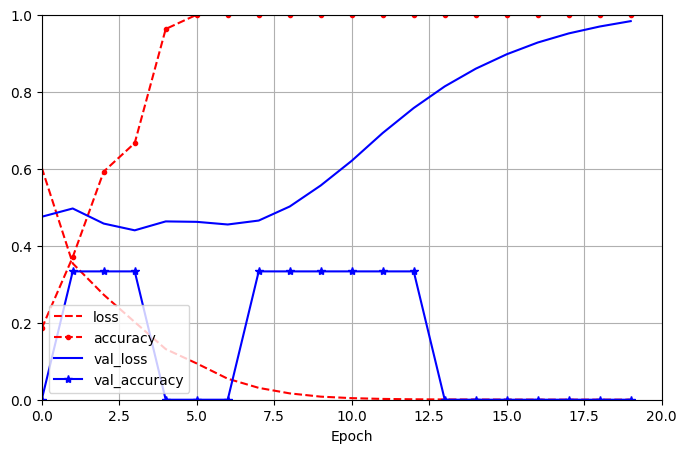

1/1 [==============================] - 0s 47ms/step


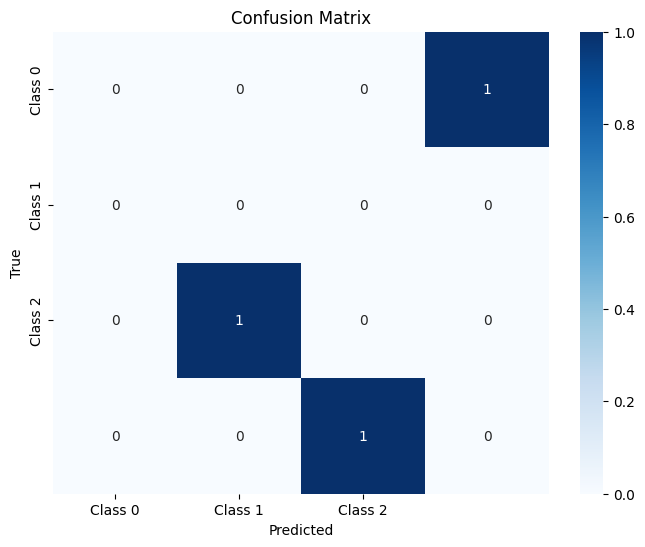

In [62]:
# try perform a whole lot of individual tests to ensure data loading is correct

import keras_nlp as nlp 
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, AveragePooling1D, Flatten, Dense
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.layers import BatchNormalization, Dropout

# test the data loading steps

input_directory = 'unit_test_data'
one_hot_encoding_labels, samples = load_data(input_directory)
        
record_file_list = find_records(input_directory)
records, all_labels = read_records(record_file_list)

def lenet1d():
    model = Sequential([
        Input(shape=(5000, 12), dtype='float32'),
        Conv1D(6, kernel_size=5, activation='relu', padding='valid', strides=1),
        AveragePooling1D(pool_size=2, padding='valid'),
        Conv1D(16, kernel_size=5, activation='relu', padding='valid', strides=1),
        AveragePooling1D(pool_size=2, padding='valid', strides=2),
        Flatten(),
        Dense(120, activation='relu'),
        Dense(84, activation='relu'),
        Dense(7, activation='sigmoid')
    ])

    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

# check every sample is 5000 long
for i in range(len(samples)):
    if len(samples[i]) != 5000:
        raise ValueError('Samples are not 5000 long')

# verify that the number of one-hot encoding dimensions is the number of unique labels
unique_labels = get_unique_classes(all_labels)

# check every sample has 12 leads
for i in range(len(samples)):
    if len(samples[i][0]) != 12:
        raise ValueError('Samples do not have 12 leads')

# check that the number of unique labels is 7
if len(unique_labels) != 7:
    raise ValueError('Incorrect number of unique labels extracted from unit test set')

# ensure one hot encoding has at least one positive label
if not np.any(one_hot_encoding_labels):
    raise ValueError('No positive labels found in one-hot encoding')

# ensure every label has the same one-hot encoding
for i in range(len(all_labels)):
    # find every other label that is the same in all_labels
    for j in range(len(all_labels)):
        if i != j:
            if all_labels[i] == all_labels[j]:
                # verify that the corresponding one-hot encoding is the same
                if not np.array_equal(one_hot_encoding_labels[i], one_hot_encoding_labels[j]):
                    raise ValueError('One-hot encoding does not match for the same label')

# check number of labels is 30 by 7
if one_hot_encoding_labels.shape != (30, 7):
    raise ValueError('Incorrect shape of labels extracted from unit test set')

# check number of samples is 30
if len(samples) != 30:
    raise ValueError('Incorrect number of samples extracted from unit test set')

model = lenet1d()

train_and_evaluate_model(model, samples, one_hot_encoding_labels, epochs=20, batch_size=12)

Epoch 1/5
516/516 [==============================] - 44s 85ms/step - loss: 0.4535 - accuracy: 0.2803 - val_loss: 0.2988 - val_accuracy: 0.3939
Epoch 2/5
516/516 [==============================] - 46s 89ms/step - loss: 0.2918 - accuracy: 0.4023 - val_loss: 0.2829 - val_accuracy: 0.3997
Epoch 3/5
516/516 [==============================] - 44s 86ms/step - loss: 0.2608 - accuracy: 0.4868 - val_loss: 0.2918 - val_accuracy: 0.4186
Epoch 4/5
516/516 [==============================] - 43s 83ms/step - loss: 0.2281 - accuracy: 0.5518 - val_loss: 0.2757 - val_accuracy: 0.4738
Epoch 5/5
516/516 [==============================] - 44s 85ms/step - loss: 0.1956 - accuracy: 0.6253 - val_loss: 0.2843 - val_accuracy: 0.4506


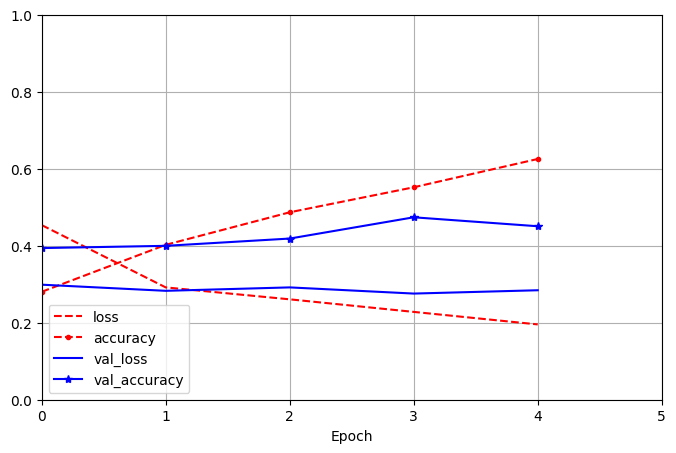

22/22 [==============================] - 1s 52ms/step


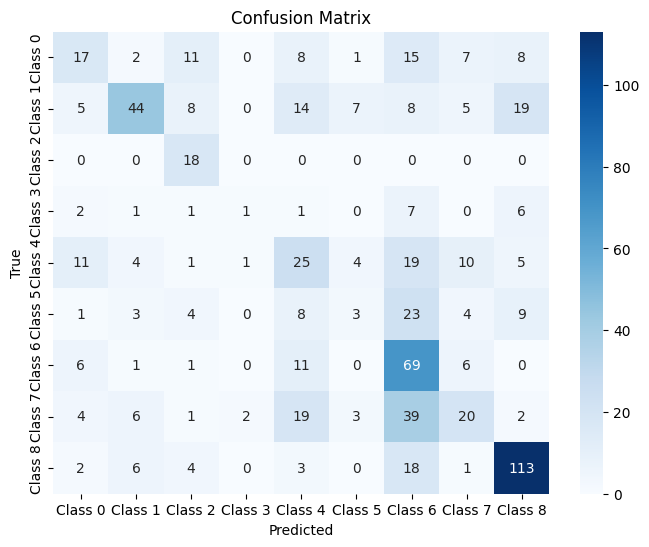

              precision    recall  f1-score   support

     Class 0       0.35      0.25      0.29        69
     Class 1       0.66      0.40      0.50       110
     Class 2       0.37      1.00      0.54        18
     Class 3       0.25      0.05      0.09        19
     Class 4       0.28      0.31      0.30        80
     Class 5       0.17      0.05      0.08        55
     Class 6       0.35      0.73      0.47        94
     Class 7       0.38      0.21      0.27        96
     Class 8       0.70      0.77      0.73       147

    accuracy                           0.45       688
   macro avg       0.39      0.42      0.36       688
weighted avg       0.45      0.45      0.42       688



In [59]:
# try a bigger capacity lenet on part of the CPSC 2018 subset

output_directory = 'output'
input_directory = 'training_data/cpsc_2018'

def biggerlenet1d(number_of_leads, num_classes, sample_length): 
    model =Sequential([
        Input(shape=(sample_length, number_of_leads), dtype='float32'),
        Conv1D(32, kernel_size=5, activation='relu', padding='valid', strides=1),
        AveragePooling1D(pool_size=2, padding='valid'),
        Conv1D(64, kernel_size=5, activation='relu', padding='valid', strides=1),
        AveragePooling1D(pool_size=2, padding='valid', strides=2),
        Conv1D(128, kernel_size=5, activation='relu', padding='valid', strides=1),
        AveragePooling1D(pool_size=2, padding='valid', strides=2),
        Flatten(),
        BatchNormalization(),
        Dropout(0.25),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.25),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.25),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.25),
        Dense(num_classes, activation='sigmoid')])
    
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model


one_hot_encoding_labels, samples = load_data(input_directory)
model = biggerlenet1d(number_of_leads=samples.shape[2], num_classes=one_hot_encoding_labels.shape[1], sample_length=samples.shape[1])  
    
train_and_evaluate_model(model, samples=samples, one_hot_encoding_labels=one_hot_encoding_labels, epochs=5, batch_size=12)

## CRT-Net

Create and train/evaluate CRT Net specifically

In [63]:
from tensorflow.keras import layers
import keras_nlp as nlp 
import tensorflow.keras as keras

def vgg_block(input, cnn_units):
    output = input
    output = layers.Conv1D(cnn_units, 3, padding='same', activation='relu')(output)
    output = layers.Conv1D(cnn_units, 3, padding='same', activation='relu')(output)
    output = layers.MaxPooling1D(2, padding='same')(output)
    return output

def crt_net(
        number_of_leads,
        cnn_units=128,
        vgg_blocks=1,
        rnn_units=64,
        transformer_encoders=4,
        att_dim=64,
        att_heads=8,
        fnn_units=64,
        num_classes=6
    ):
    input = layers.Input(shape=(None, number_of_leads))
    output = input

    for _ in range(vgg_blocks):
        output = vgg_block(output, cnn_units)

    output = layers.Bidirectional(layers.GRU(rnn_units, return_sequences=True), merge_mode='sum')(output)

    if transformer_encoders > 0:
        output = output + nlp.layers.SinePositionEncoding(max_wavelength=10000)(output)

        for _ in range(transformer_encoders):
            output = nlp.layers.TransformerEncoder(att_dim, att_heads)(output)

        output = layers.GlobalAveragePooling1D()(output)
        
    output = layers.Dropout(0.2)(output)
    output = layers.Dense(fnn_units, activation='relu')(output)
    output = layers.Dense(fnn_units, activation='relu')(output)

    output = layers.Dense(num_classes, activation='sigmoid')(output)
    model = keras.Model(input, output)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

    return model


In [64]:
output_directory = 'output'
input_directory = 'training_data/cpsc_2018_subset'
    
stopping = keras.callbacks.EarlyStopping(patience=5)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    factor=0.1,
    patience=3,
    min_lr= 0.001*0.001)

filepath = os.path.join('output', "model.h5")

#checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)
        
one_hot_encoding_labels, samples = load_data(input_directory)

model = crt_net(number_of_leads=samples.shape[2], num_classes=one_hot_encoding_labels.shape[1])  
    
train_and_evaluate_model(model, samples=samples, one_hot_encoding_labels=one_hot_encoding_labels,callbacks=[stopping, reduce_lr])


Epoch 1/10
 5/75 [=>............................] - ETA: 10:57 - loss: 0.5913 - accuracy: 0.1333 

KeyboardInterrupt: 